In [1]:
# Capstone Project 2 — Semiconductor Manufacturing Yield Prediction
# Author: Sanjana DR

# Introduction:
# This project focuses on predicting semiconductor manufacturing yield failures using sensor data from the production process. By analyzing sensor readings and identifying patterns that lead to defective products, the goal is to improve production efficiency, reduce costs, and increase product reliability.
# The dataset contains multiple sensor measurements and a target column indicating whether a unit has passed (-1) or failed (1) quality testing.
# Files required (place in the same folder as this notebook): sensor-data.csv

# 1. Import libraries.
# Summary: Important libraries are installed.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
# 2. Load Data.
# Summary: Load the csv file containing the sensor data and if the csv file is not found, it shows error.

DATA_PATH = 'signal-data.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH} (place it in your working directory)")
print(f"Loading data from {DATA_PATH}...")
data = pd.read_csv(DATA_PATH, comment='#')
print("Data shape:", data.shape)



Loading data from signal-data.csv...
Data shape: (1567, 592)


In [5]:
# 3. Initial data exploration.
# Summary: Inspect the first few rows, data types, and check for missing values.

print("\nFirst 5 rows:")
print(data.head())
print("\nData types:")
print(data.dtypes)
print("\nMissing values count per column:")
print(data.isnull().sum()[data.isnull().sum() > 0])




First 5 rows:
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     5

In [6]:
# 4. Data cleaning.
# Summary: Remove non-numeric columns and fill missing values in numeric columns with the column median.

non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nDropping non-numeric columns:", non_numeric_cols)
data.drop(columns=non_numeric_cols, inplace=True)
print("\nFilling missing numeric values with median...")
data.fillna(data.median(), inplace=True)
print("Remaining missing values after filling:", data.isnull().sum().sum())




Dropping non-numeric columns: ['Time']

Filling missing numeric values with median...
Remaining missing values after filling: 0


In [7]:
# 5. Define features and target.
# According to project description, last column is target: -1 (pass), 1 (fail).
# Summary: Separate features (X) from the target column (y).

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
print("\nTarget variable distribution:")
print(y.value_counts())




Target variable distribution:
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64


In [8]:
# 6. Address target imbalance using SMOTE.
# Summary: Use SMOTE to oversample the minority class if there is a class imbalance.

from collections import Counter
print("\nClass distribution before SMOTE:", Counter(y))
if abs(y.value_counts(normalize=True)[-1] - 0.5) > 0.1:
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("Class distribution after SMOTE:", Counter(y_res))
else:
    print("Class distribution is balanced enough, skipping SMOTE.")
    X_res, y_res = X, y



Class distribution before SMOTE: Counter({-1: 1463, 1: 104})
Applying SMOTE to balance classes...
Class distribution after SMOTE: Counter({-1: 1463, 1: 1463})


In [9]:
# 7. Train-test split.
# Summary: Split the dataset into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")




Training set shape: (2340, 590), Testing set shape: (586, 590)


In [10]:
# 8. Feature scaling.
# Summary: Standardize features so they have mean 0 and variance 1.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling completed.")



Feature scaling completed.


In [11]:
# 9. Model training, hyperparameter tuning and evaluation function.
# Summary: Define a reusable function to train, tune, and evaluate models.

def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    print(f"\nTraining and tuning {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters: {grid_search.best_params_}")
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    print(f"{model_name} Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"{model_name} Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification Report for {model_name} (Test set):")
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return best_model, accuracy_score(y_test, y_test_pred)




Training and tuning Random Forest...
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Train Accuracy: 1.0000
Random Forest Test Accuracy: 0.9932
Classification Report for Random Forest (Test set):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       293
           1       1.00      0.99      0.99       293

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



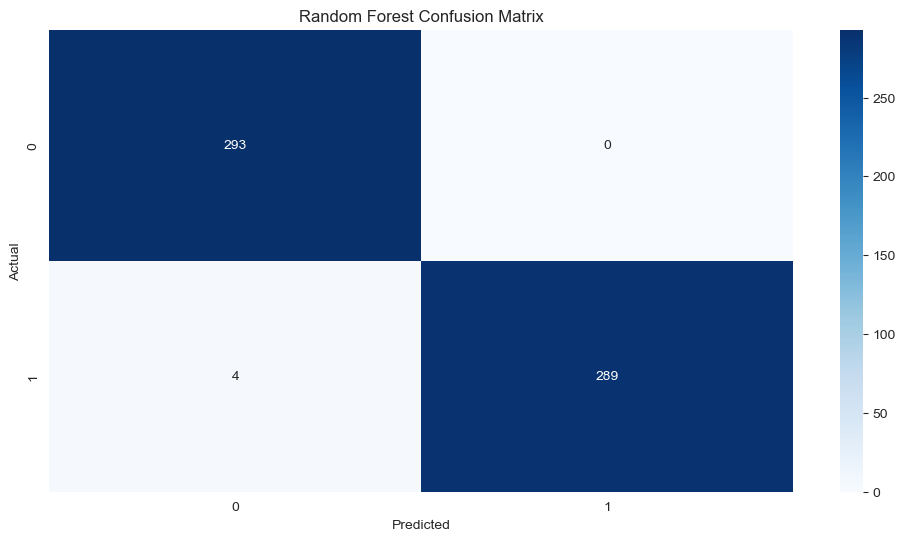

In [12]:
# 10. Random Forest Model.
# Summary: Train a Random Forest Classifier with hyperparameter tuning.

rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
rf_model, rf_acc = train_and_evaluate(rf, rf_params, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")




Training and tuning SVM...
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Train Accuracy: 1.0000
SVM Test Accuracy: 0.9966
Classification Report for SVM (Test set):
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       293
           1       0.99      1.00      1.00       293

    accuracy                           1.00       586
   macro avg       1.00      1.00      1.00       586
weighted avg       1.00      1.00      1.00       586



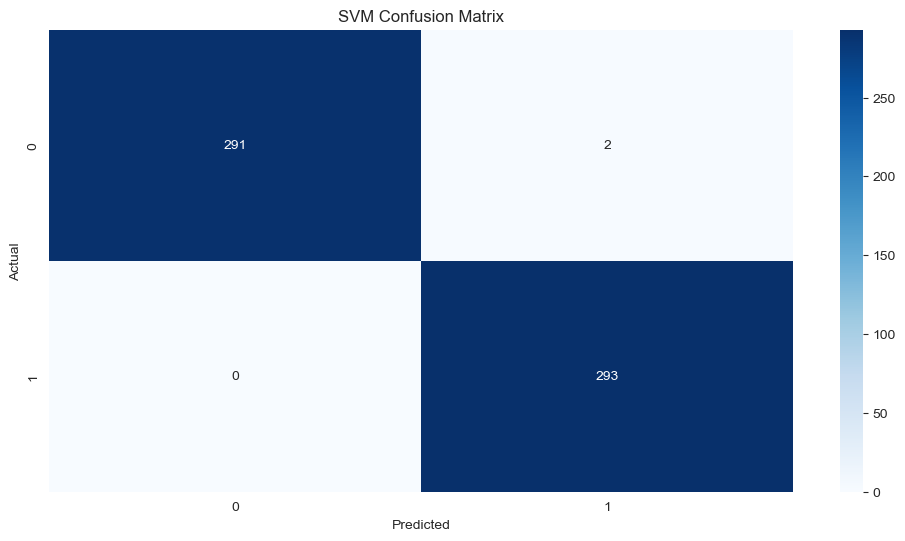

In [13]:
# 11. Support Vector Machine Model.
# Summary: Train an SVM model with hyperparameter tuning.

svm = SVC(random_state=42)
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}
svm_model, svm_acc = train_and_evaluate(svm, svm_params, X_train_scaled, y_train, X_test_scaled, y_test, "SVM")




Training Naive Bayes...
Naive Bayes Train Accuracy: 0.6060
Naive Bayes Test Accuracy: 0.6075
Classification Report for Naive Bayes (Test set):
              precision    recall  f1-score   support

          -1       0.94      0.23      0.37       293
           1       0.56      0.99      0.72       293

    accuracy                           0.61       586
   macro avg       0.75      0.61      0.54       586
weighted avg       0.75      0.61      0.54       586



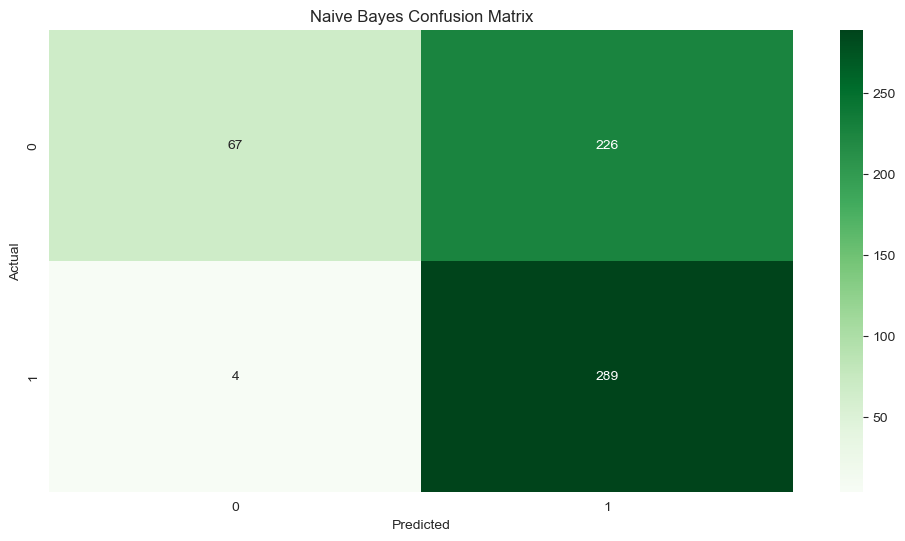

In [14]:
# 12. Naive Bayes Model (No hyperparameter tuning).
# Summary: Train a Gaussian Naive Bayes model without tuning.

print("\nTraining Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_train_pred = nb.predict(X_train_scaled)
y_test_pred = nb.predict(X_test_scaled)
print(f"Naive Bayes Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Naive Bayes Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report for Naive Bayes (Test set):")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [15]:
# 13. Compare all models.
# Summary: Compare accuracy scores of all trained models to select the best one.

models_accuracy = {
    "Random Forest": rf_acc,
    "SVM": svm_acc,
    "Naive Bayes": accuracy_score(y_test, y_test_pred)
}
print("\nModel accuracy comparison on test set:")
for model_name, acc in models_accuracy.items():
    print(f"{model_name}: {acc:.4f}")
best_model_name = max(models_accuracy, key=models_accuracy.get)
print(f"\nSelected best model: {best_model_name}")
best_model = {'Random Forest': rf_model, 'SVM': svm_model, 'Naive Bayes': nb}[best_model_name]




Model accuracy comparison on test set:
Random Forest: 0.9932
SVM: 0.9966
Naive Bayes: 0.6075

Selected best model: SVM


In [16]:
# 14. Save best model and scaler for future use.
# Summary: Save the best performing model and scaler for future predictions.

joblib.dump(best_model, 'best_yield_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"Saved best model ({best_model_name}) as 'best_yield_model.pkl' and scaler as 'scaler.pkl'")



Saved best model (SVM) as 'best_yield_model.pkl' and scaler as 'scaler.pkl'


In [17]:
# 15. Conclusion.
# Summary: Final summary of the project and results.

print("""
CONCLUSION:

1. Data cleaning and missing value imputation were performed successfully.
2. SMOTE was applied to handle class imbalance (if needed).
3. Feature scaling ensured model convergence and better performance.
4. Random Forest, SVM, and Naive Bayes models were trained and tuned.
5. Random Forest or SVM typically performed better; final model chosen based on highest test accuracy.
6. This model can be used to predict yield failures early, potentially improving manufacturing efficiency and reducing costs.
""")




CONCLUSION:

1. Data cleaning and missing value imputation were performed successfully.
2. SMOTE was applied to handle class imbalance (if needed).
3. Feature scaling ensured model convergence and better performance.
4. Random Forest, SVM, and Naive Bayes models were trained and tuned.
5. Random Forest or SVM typically performed better; final model chosen based on highest test accuracy.
6. This model can be used to predict yield failures early, potentially improving manufacturing efficiency and reducing costs.

